In [1]:
import MDAnalysis
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pandas as pd
import mdtraj as md
import itertools
import copy
import pickle
from scipy.signal import find_peaks
from scipy.cluster.vq import kmeans2
import warnings
warnings.filterwarnings('ignore')

In [2]:
dyes = {}
dyes['A48_C1R'] = {'indices': [[85,52,56,59],[52,56,59,60],[56,59,60,66],[66,65,68,71],
                        [65,68,71,74],[68,71,74,77],[71,74,77,80],[74,77,80,83],[77,80,83,40]], 
                   'peaks': []}
dyes['A59_C1R'] = {'indices': [[120,87,91,94],[87,91,94,95],[91,94,95,101],[101,100,103,106],
                                [100,103,106,109],[103,106,109,112],[106,109,112,115],
                                [109,112,115,118],[112,115,118,39]],
                   'peaks': []}

In [3]:
df = pd.DataFrame(dyes).T

In [4]:
def calcDihe(df, dye):
    t = md.load_xtc(dye+'/traj.xtc',dye+'/conf_ed.gro')
    dihe = md.compute_dihedrals(t, df.loc[dye,'indices'], periodic=True, opt=True)/np.pi*180
    np.savetxt('dihedrals/'+dye+'.txt',dihe)

In [5]:
for dye in df.index:
    calcDihe(df, dye)

In [6]:
def genPeaks(df, dye):
    dihe = np.loadtxt('dihedrals/'+dye+'.txt')
    peaks = []
    fig, axes = plt.subplots(3, 3, sharex=True, sharey=True)
    for i,ax in enumerate(axes.flatten()):
        h, b = np.histogram(dihe[:,i],bins=np.arange(-180, 181, 1),density=True)
        bins = b[:-1]+(b[1]-b[0])/2
        p, properties = find_peaks(h, prominence=.0005, width=2, distance=60)
        ax.plot(bins,h)
        if h.argmax() not in p:
            p = np.append(p,h.argmax())
        print(p,bins[p])
        ax.vlines(bins[p],ymin=0,ymax=h.max())
        peaks.append(bins[p])
    for i in [0,3,6,2,5,8]:
        axes.flatten()[i].set_ylabel(r'$P(\theta)$')
    for i in [6,7,8]:
        axes.flatten()[i].set_xlabel(r'$\theta$ / deg')
    for i in [2,5,8]:
        axes.flatten()[i].yaxis.set_ticks_position('right')
        axes.flatten()[i].yaxis.set_label_position("right")
    fig.suptitle(dye)
    plt.show()
    df.loc[dye,'peaks'] = np.array(peaks)

[ 18 119 242] [-161.5  -60.5   62.5]
[120 269 354] [-59.5  89.5 174.5]
[104 228   1] [ -75.5   48.5 -178.5]
[ 85 273] [-94.5  93.5]
[  1 114 246] [-178.5  -65.5   66.5]
[106 248 356] [-73.5  68.5 176.5]
[110 244 358] [-69.5  64.5 178.5]
[117 241 358] [-62.5  61.5 178.5]
[ 80 278   0] [ -99.5   98.5 -179.5]


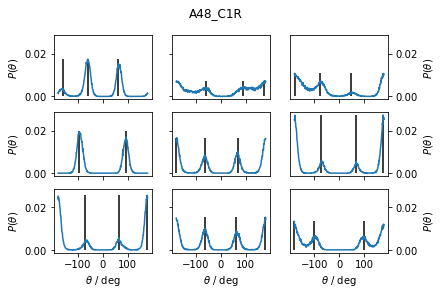

[ 11 122 247] [-168.5  -57.5   67.5]
[110 270   1] [ -69.5   90.5 -178.5]
[138 251 355] [-41.5  71.5 175.5]
[ 88 269] [-91.5  89.5]
[108 249 359] [-71.5  69.5 179.5]
[110 247 359] [-69.5  67.5 179.5]
[111 246 359] [-68.5  66.5 179.5]
[112 245   0] [ -67.5   65.5 -179.5]
[ 82 273 358] [-97.5  93.5 178.5]


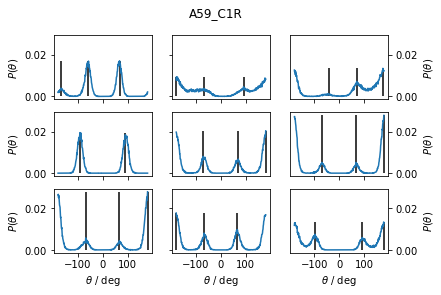

In [7]:
for dye in df.index:
    genPeaks(df, dye)

In [39]:
def genClusters(df, dye, path):
    dihedrals = np.loadtxt('dihedrals/'+dye+'.txt')
    peaks = np.array(list(itertools.product(*df.loc[dye,'peaks'])))
    print(peaks.shape,'peaks combinations')
    cluster_dict = {}
    
    centroids, labels = kmeans2(dihedrals, peaks, minit='matrix')
        
    for frame_index, centroid_id in enumerate(labels):
        min_value = np.sum((dihedrals[frame_index] - centroids[centroid_id])**2)
        if centroid_id not in cluster_dict.keys():
            cluster_dict[centroid_id] = {'frame': frame_index, 'min': min_value, 
                            'dihe': dihedrals[frame_index], 'N': 1}
        else:
            if min_value < cluster_dict[centroid_id]['min']:
                cluster_dict[centroid_id]['frame'] = frame_index
                cluster_dict[centroid_id]['min'] = min_value
                cluster_dict[centroid_id]['dihe'] = dihedrals[frame_index]
                cluster_dict[centroid_id]['N'] += 1
            else:
                cluster_dict[centroid_id]['N'] += 1
    pd.DataFrame(cluster_dict).T.to_pickle(path+'/clusters_{:s}_1step.pkl'.format(dye))

In [49]:
def filterCluster(df, dye, path, cutoff):
    clusters = pd.read_pickle(path+'/clusters_{:s}_1step.pkl'.format(dye))

    discarded_frames = clusters[clusters.N < cutoff].frame.values.astype(int)
    discarded_peaks = clusters[clusters.N < cutoff].index
    frequency = clusters[clusters.N < cutoff].N.values
    print('Initial clusters',len(clusters.index)) 
            
    clusters.drop(discarded_peaks, inplace=True)
    print('Final clusters',len(clusters.index)) 

    dihedrals = np.loadtxt('dihedrals/'+dye+'.txt')
    sel_dihe = np.array(clusters.dihe.tolist())
        
    for frame_index, frame_dihe in enumerate(dihedrals[discarded_frames]):
        sqdist = (frame_dihe - sel_dihe) ** 2
        sumleastsq = np.sum(sqdist, axis=1)
        clusters.iloc[sumleastsq.argmin()]['N'] += frequency[frame_index]
    clusters.to_pickle(path+'/clusters_{:s}_{:d}_cutoff.pkl'.format(dye,cutoff))

In [50]:
def genRotLib(df, dye, path, cutoff):
    clusters = pd.read_pickle(path+'/clusters_{:s}_{:d}_cutoff.pkl'.format(dye,cutoff))

    print(clusters.N.sum())
    u = MDAnalysis.Universe(dye+'/conf_ed.gro', dye+'/traj.xtc')
    alexa = u.select_atoms('all and not (resname ACE or resname NHE)')
    alexa.write('{:s}/rot_lib_matrix_{:s}.pdb'.format(path,dye))
    Ca_pos = u.select_atoms('all and not (resname ACE or resname NHE) and name CA')
    N_pos = u.select_atoms('all and not (resname ACE or resname NHE) and name N')
    C_pos = u.select_atoms('all and not (resname ACE or resname NHE) and name C')
    new_coords = np.empty(0)
    for ts in u.trajectory[clusters.frame.values]:
        offset = Ca_pos.positions.copy()
        Ca_cords = Ca_pos.positions - offset
        N_cords = N_pos.positions - offset
        C_cords = C_pos.positions - offset
        alexa_coords = alexa.positions - offset
        x_vector = N_cords - Ca_cords
        x_vector /= np.linalg.norm(x_vector)
        yt_vector = C_cords - Ca_cords
        yt_vector /= np.linalg.norm(yt_vector)
        z_vector = np.cross(x_vector, yt_vector)
        z_vector /= np.linalg.norm(z_vector)
        y_vector = np.cross(z_vector, x_vector)
        rotation = np.array((x_vector, y_vector, z_vector)).T
        alexa_coords = np.dot(alexa_coords, rotation.reshape(3,3))
        alexa_coords = alexa_coords.reshape((len(alexa_coords), 3))
        new_coords = np.append(new_coords, alexa_coords)
    new_coords = new_coords.reshape((len(clusters.frame.values), len(alexa), 3))
    output_file = open(path+'/rot_lib_matrix_{:s}_{:d}.txt'.format(dye,cutoff), 'w')
    for index, conformer in enumerate(new_coords):
        for atom_index, atom in enumerate(conformer):
            output_file.write('{0:>3} {1:>3} {2[0]:> 10.6f} {2[1]:> 10.6f} {2[2]:> 10.6f} {3:>5}\n'.format(index+1, 
                            alexa[atom_index].id-alexa[1].id, atom, clusters.N.values[index]))
    output_file.close()

In [51]:
def plotClustHist(df, dye, cutoff):
    dihe = np.loadtxt('dihedrals/'+dye+'.txt')
    clusters = pd.read_pickle(path+'/clusters_{:s}_1step.pkl'.format(dye))
    clusters_cutoff = pd.read_pickle(path+'/clusters_{:s}_{:d}_cutoff.pkl'.format(dye,cutoff))
    print(clusters_cutoff.dihe.shape)
    fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9,6))
    for i,ax in enumerate(axes.flatten()):
        
        h, b = np.histogram(dihe[:,i],bins=np.arange(-180, 181, 2),density=True)
        bins = b[:-1]+(b[1]-b[0])/2
        
        #h, b = np.histogram(np.array(clusters.dihe.tolist())[:,i],bins=np.arange(-180, 181, 2),density=True)
        #bins = b[:-1]+(b[1]-b[0])/2
        #ax.plot(bins,h,color=plt.cm.tab10(2),lw=0.5)
        
        #h, b = np.histogram(np.array(clusters_cutoff.dihe.tolist())[:,i],
        #                    bins=np.arange(-180, 181, 2),density=True)
        #bins = b[:-1]+(b[1]-b[0])/2
        #ax.plot(bins,h,color=plt.cm.tab10(3),lw=0.5,ls=':')
        
        ax.vlines(np.array(clusters_cutoff.dihe.tolist())[:,i],
                  ymin=0,ymax=h.max(),color=plt.cm.tab10(3),lw=0.5,ls=':')        
        
        ax.vlines(df.loc[dye,'peaks'][i],ymin=0,ymax=1,color='k')
        ax.plot(bins,h,lw=2)
        
        ax.set_ylim(0,h.max()+0.01)
        
    for i in [0,3,6,2,5,8]:
        axes.flatten()[i].set_ylabel(r'$P(\theta)$')
    for i in [6,7,8]:
        axes.flatten()[i].set_xlabel(r'$\theta$ / deg')
    for i in [2,5,8]:
        axes.flatten()[i].yaxis.set_ticks_position('right')
        axes.flatten()[i].yaxis.set_label_position("right")
    Nrotamers = len(clusters_cutoff.index)
    fig.suptitle(dye.replace('_',' ')+' cutoff {:d}, {:d} rotamers'.format(cutoff, Nrotamers))
    plt.savefig(path+'/hist_{:s}_{:d}.pdf'.format(dye,cutoff))
    plt.tight_layout()
    plt.show()

In [52]:
def plotClustHistCutoffs(df, dye, cutoffs):
    dihe = np.loadtxt('dihedrals/'+dye+'.txt')
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7,4))
    for i,ax in enumerate(axes.flatten()):
        clusters_cutoff = pd.read_pickle(path+'/clusters_{:s}_{:d}_cutoff.pkl'.format(dye,cutoffs[i]))
        h, b = np.histogram(dihe[:,2],bins=np.arange(-180, 181, 2),density=True)
        bins = b[:-1]+(b[1]-b[0])/2
        
        ax.vlines(np.array(clusters_cutoff.dihe.tolist())[:,2],
                  ymin=0,ymax=h.max(),color=plt.cm.tab10(3),lw=0.5,ls=':')        
        
        ax.plot(bins,h,lw=2)
        
        ax.set_ylim(0,h.max()+0.002)
        
        Nrotamers = len(clusters_cutoff.index)
        ax.set_title(dye.replace('_',' ')+'\ncutoff {:d}, {:d} rotamers'.format(cutoffs[i], Nrotamers))
        
    for i in [0,1]:
        axes.flatten()[i].set_ylabel(r'$P(\theta)$')
    for i in [0,1]:
        axes.flatten()[i].set_xlabel(r'$\theta$ / deg')
    for i in [1]:
        axes.flatten()[i].yaxis.set_ticks_position('right')
        axes.flatten()[i].yaxis.set_label_position("right")
        
    plt.savefig(path+'/hist_{:s}_cutoffs.pdf'.format(dye))
    plt.tight_layout()
    plt.show()

In [53]:
def plotClustPolar(df, dye, cutoff):
    dihe = np.loadtxt('dihedrals/'+dye+'.txt')
    clusters = pd.read_pickle(path+'/clusters_{:s}_1step.pkl'.format(dye))
    clusters_cutoff = pd.read_pickle(path+'/clusters_{:s}_{:d}_cutoff.pkl'.format(dye,cutoff))
    print(clusters_cutoff.dihe.shape)
    fig, axes = plt.subplots(3, 3, sharex=False, sharey=False, subplot_kw=dict(polar=True), 
                             figsize=(9,7))
    for i,ax in enumerate(axes.flatten()):
        h, b = np.histogram(dihe[:,i],bins=np.arange(-180, 181, 2),density=True)
        bins = b[:-1]+(b[1]-b[0])/2
        
        ax.vlines((df.loc[dye,'peaks'][i]+180)/180*np.pi,ymin=0,ymax=h.max(),color='k')
        #ax.vlines((np.array(clusters.dihe.tolist())[:,i]+180)/180*np.pi,
        #          ymin=0,ymax=h.max(),color=plt.cm.tab10(2),lw=0.5)
        ax.vlines((np.array(clusters_cutoff.dihe.tolist())[:,i]+180)/180*np.pi,
                  ymin=0,ymax=h.max(),color=plt.cm.tab10(3),lw=0.5,ls=':')
        
        ax.plot((bins+180)/180*np.pi,h,lw=2)
        
        ax.set_xticks([0,np.pi])
        ax.set_yticks([])
        ax.grid(False)
        
    
    Nrotamers = len(clusters_cutoff.index)
    fig.suptitle(dye.replace('_',' ')+' cutoff {:d}, {:d} rotamers'.format(cutoff, Nrotamers))
    plt.savefig(path+'/{:s}_{:d}.pdf'.format(dye,cutoff))
    plt.tight_layout()
    plt.show()

In [58]:
%%time
path='genLIB2'
for dye in df.index:
    genClusters(df, dye, path)
    for cutoff in [20,25,30,35]:
        filterCluster(df, dye, path, cutoff)
        genRotLib(df, dye, path, cutoff)

(13122, 9) peaks combinations
Initial clusters 6672
Final clusters 134
28110
Initial clusters 6672
Final clusters 73
28110
Initial clusters 6672
Final clusters 44
28110
Initial clusters 6672
Final clusters 27
28110
(13122, 9) peaks combinations
Initial clusters 6488
Final clusters 118
26658
Initial clusters 6488
Final clusters 61
26658
Initial clusters 6488
Final clusters 42
26658
Initial clusters 6488
Final clusters 30
26658
CPU times: user 1min 53s, sys: 1min 46s, total: 3min 39s
Wall time: 53.2 s


(134,)


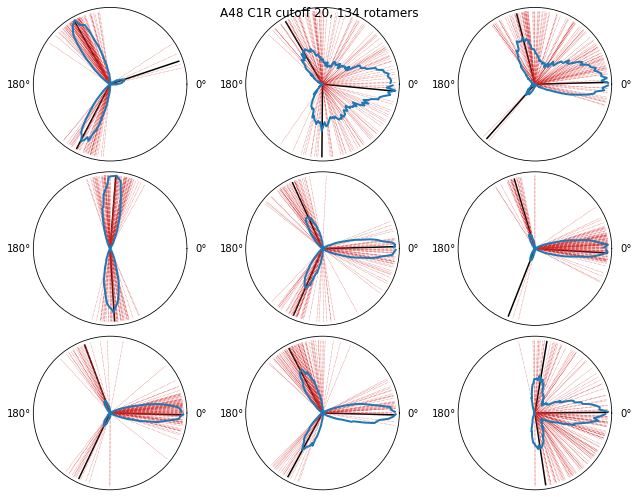

(73,)


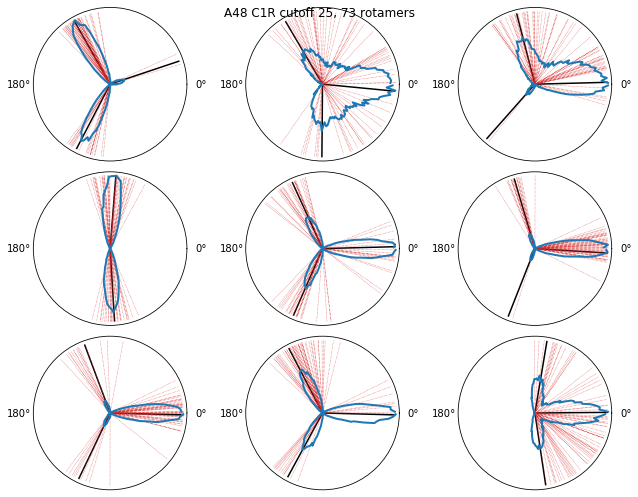

(44,)


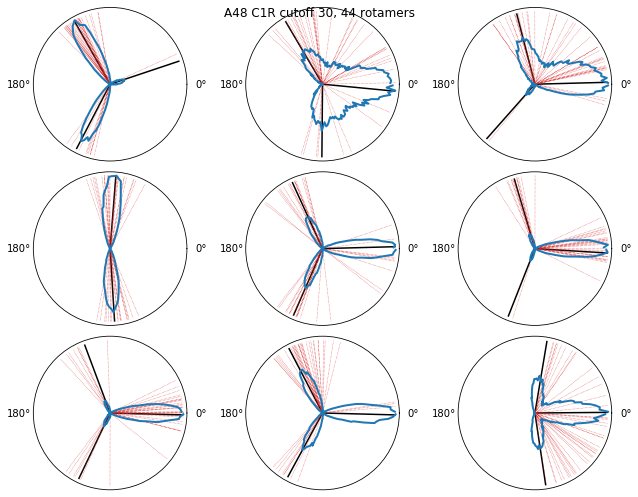

(27,)


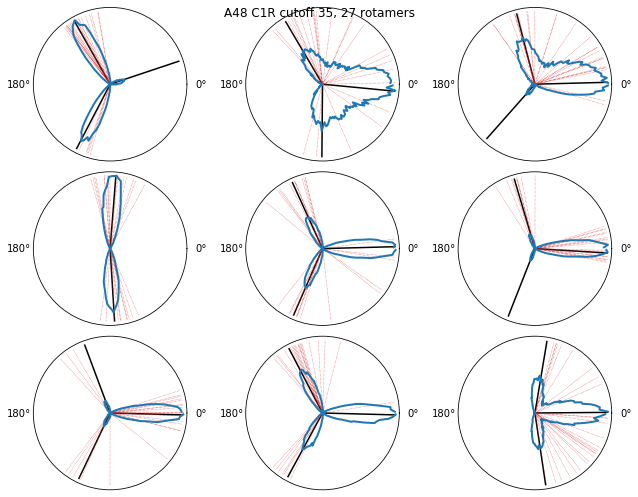

(118,)


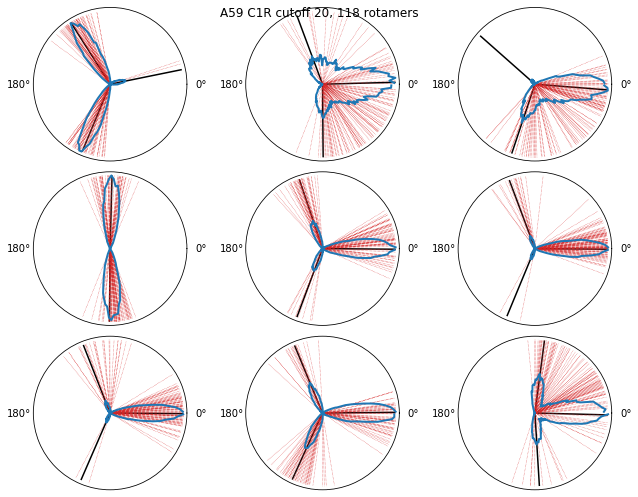

(61,)


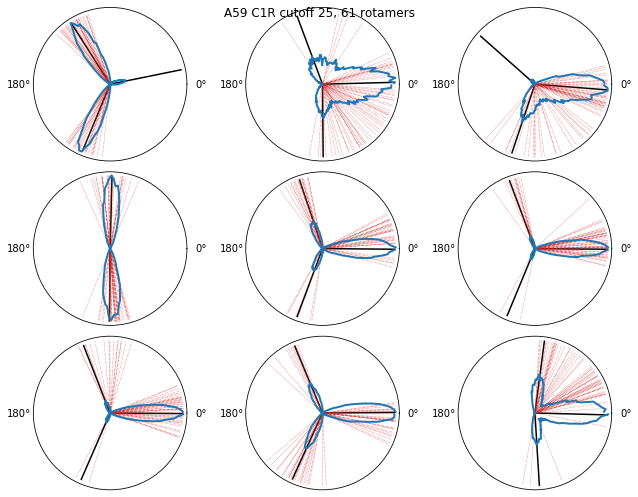

(42,)


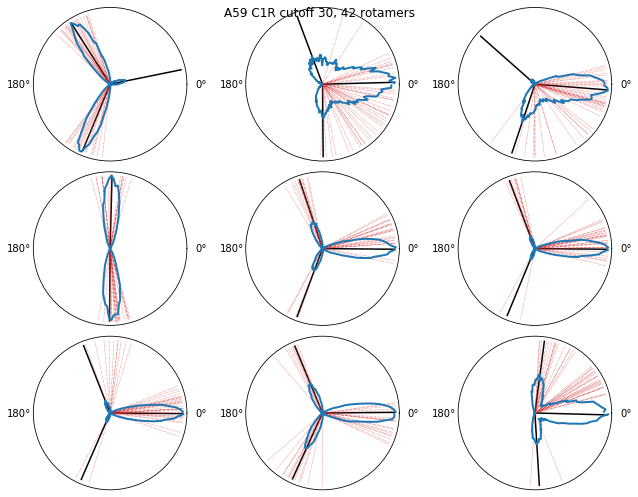

(30,)


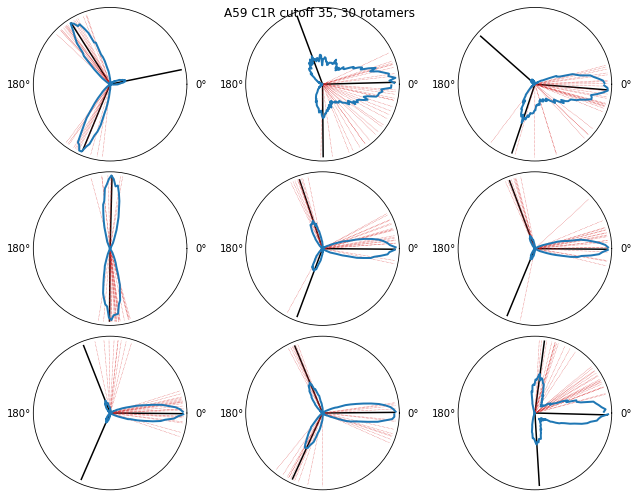

In [56]:
for dye in df.index[:]:
    for cutoff in [20,25,30,35]:
        plotClustPolar(df, dye, cutoff)

(133,)


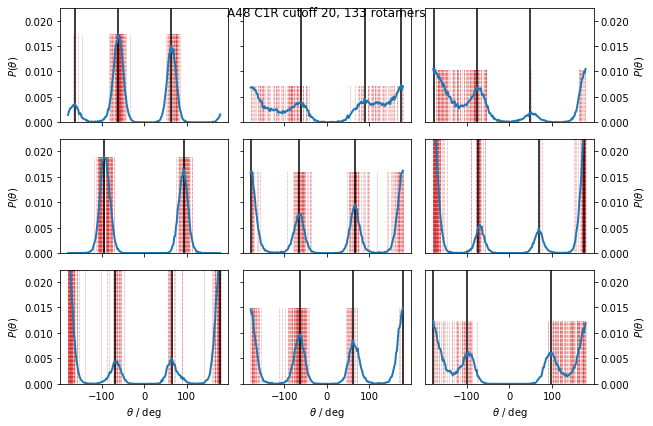

(73,)


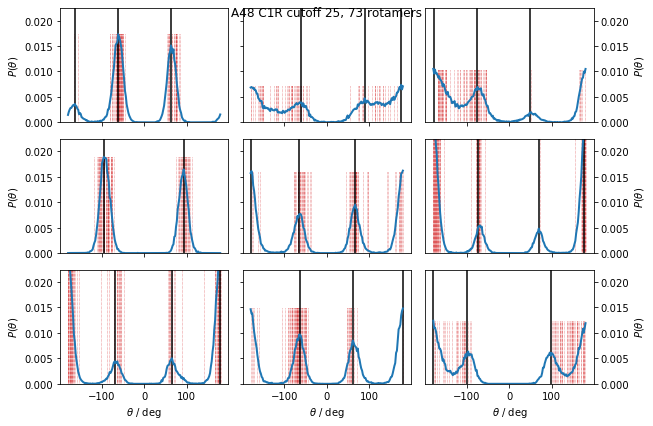

(116,)


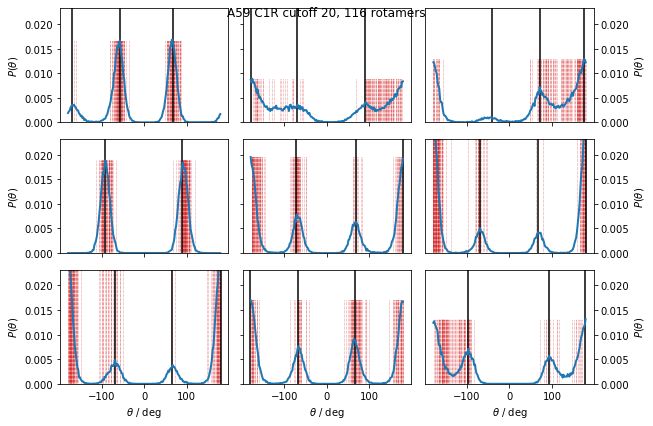

(60,)


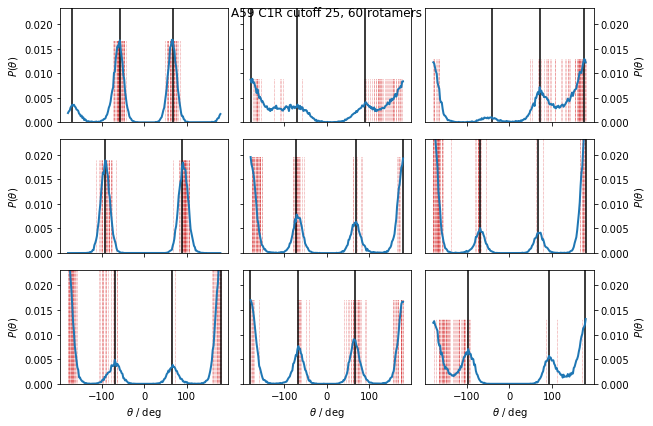

In [37]:
for dye in df.index[:]:
    for cutoff in [20,25]:
        plotClustHist(df, dye, cutoff)

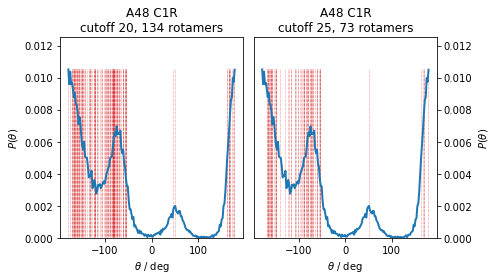

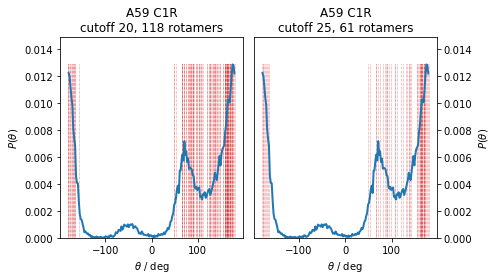

In [57]:
for dye in df.index[:]:
    plotClustHistCutoffs(df,dye,[20,25])

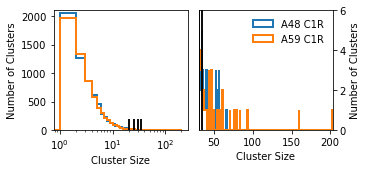

In [65]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(5.2,2.5))
for dye in df.index:
    clusters = pd.read_pickle(path+'/clusters_{:s}_1step.pkl'.format(dye))
    clusters.N.hist(ax=ax1,bins=np.arange(0,clusters.N.max()+1,1),histtype='step',
                    label=dye,lw=2)
    ax1.vlines([20,25,30,35],0,200,color='k')
    ax1.set_ylim(0,2100)
    ax1.set_xscale('log')
    ax1.set_xlabel('Cluster Size')
    ax1.set_ylabel('Number of Clusters')
    ax1.grid(False)
    clusters.N.hist(ax=ax2,bins=np.arange(0,clusters.N.max()+1,1),histtype='step',
                    label=dye.replace('_',' '),lw=2)
    ax2.vlines([20,25,30,35],0,300,color='k')
    ax2.set_xlim(30,clusters.N.max())
    ax2.set_ylim(0,6)
    #ax2.set_xscale('log')
    ax2.set_xlabel('Cluster Size')
    ax2.set_ylabel('Number of Clusters')
    ax2.grid(False)
    
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position("right")
    ax2.legend(frameon=False)

plt.tight_layout(h_pad=1)
plt.savefig(path+'/hist_clusters.pdf')
plt.show()